## Train

In [1]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]
!pip install rouge_score
!pip install transformers[torch]
!pip install csv
!pip install pandas
!pip install scikit-learn

In [2]:
# !gsutil cp -r gs://vietai_public/viT5/data/vietnews .
# !gsutil cp -r gs://vietai_public/viT5/data/wikilingua .


In [3]:
from google.colab import drive
drive.mount('/colabDrive')
# filePath="/colabDrive/MyDrive/colabDrive/hyperSmallDataset.csv"

Mounted at /colabDrive


In [4]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import csv

In [5]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")
model.to('cuda')

In [6]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=512, truncation=True, padding=True
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=512, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    return model_inputs

In [7]:
# Deprecated
# input_lines = []
# label_lines = []

# train_file = '/colabDrive/MyDrive/colabDrive/miniDataset.csv'

# with open(f'{train_file}', newline='') as file:
#     reader = csv.reader(file)
#     for line in reader:
#         input_lines.append(line[0] +'</s>')
#         label_lines.append(line[1])

# dict_obj = {'inputs': input_lines, 'labels': label_lines}
# dataset = Dataset.from_dict(dict_obj)
# tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

In [8]:
# input_lines

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_file = '/colabDrive/MyDrive/colabDrive/miniDataset.csv'
# Read the CSV file using pandas
df = pd.read_csv(train_file)

# Assuming `dataset` is your original dataset
train_dataset, eval_dataset = train_test_split(df, test_size=0.2)

def prepareDataset(df):
    # Convert the columns to lists
    input_lines = df['AccentlessSentences'].tolist()
    label_lines = df['Sentences'].tolist()

    # Append '</s>' to each input line
    input_lines = [line + '</s>' for line in input_lines]

    dict_obj = {'inputs': input_lines, 'labels': label_lines}
    dataset = Dataset.from_dict(dict_obj)
    tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)
    return tokenized_datasets

tokenized_training_datasets=prepareDataset(train_dataset)
tokenized_eval_datasets=prepareDataset(eval_dataset)


Map (num_proc=8):   0%|          | 0/4000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map (num_proc=8):   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [10]:

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")


training_args = Seq2SeqTrainingArguments("tmp/",
                                      do_train=True,
                                      do_eval=True,
                                      num_train_epochs=5,
                                      learning_rate=1e-5,
                                      warmup_ratio=0.05,
                                      weight_decay=0.01,
                                      per_device_train_batch_size=7,
                                      per_device_eval_batch_size=7,
                                      logging_dir='./log',
                                      group_by_length=True,
                                      save_strategy="epoch",
                                      save_total_limit=3,
                                      eval_steps=1000,
                                      evaluation_strategy="steps",
                                      logging_steps=1000,
                                      logging_strategy="steps",
                                      fp16=True,
                                      )


# AdaFactor for ViT5-large models as it based on T5v1.1.
# See https://medium.com/the-artificial-impostor/paper-adafactor-adaptive-learning-rates-with-sublinear-memory-cost-a543abffa37
#
# from transformers.optimization import Adafactor, AdafactorSchedule
# optimizer = Adafactor(
#     model.parameters(),
#     lr=1e-3,
#     eps=(1e-30, 1e-3),
#     clip_threshold=1.0,
#     decay_rate=-0.8,
#     beta1=None,
#     weight_decay=0.0,
#     relative_step=False,
#     scale_parameter=False,
#     warmup_init=False
# )
# lr_scheduler = AdafactorSchedule(optimizer)


In [11]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_training_datasets,
    eval_dataset=tokenized_eval_datasets,
    data_collator=data_collator,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,3.898300,0.105536
2,0.085800,0.065319
3,0.057100,0.054132
4,0.044900,0.048314
5,0.037600,0.046811


TrainOutput(global_step=2860, training_loss=0.7253615589408607, metrics={'train_runtime': 1805.616, 'train_samples_per_second': 11.077, 'train_steps_per_second': 1.584, 'total_flos': 7494520878858240.0, 'train_loss': 0.7253615589408607, 'epoch': 5.0})

In [12]:

# After training, you can evaluate the model like this:
metrics = trainer.evaluate()

print(metrics)

{'eval_loss': 0.046810559928417206, 'eval_runtime': 15.5207, 'eval_samples_per_second': 64.43, 'eval_steps_per_second': 9.213, 'epoch': 5.0}


In [13]:

# Save the model
trainer.save_model('/colabDrive/MyDrive/colabDrive/testModel')
#tokenizer.save_pretrained("/colabDrive/MyDrive/colabDrive/myTokenizer")

In [17]:
trainer.state.log_history

[{'loss': 3.8983,
  'learning_rate': 8.708133971291867e-06,
  'epoch': 0.87,
  'step': 500},
 {'eval_loss': 0.1055358275771141,
  'eval_runtime': 15.8098,
  'eval_samples_per_second': 63.252,
  'eval_steps_per_second': 9.045,
  'epoch': 1.0,
  'step': 572},
 {'loss': 0.0858,
  'learning_rate': 6.867868973132131e-06,
  'epoch': 1.75,
  'step': 1000},
 {'eval_loss': 0.0653185322880745,
  'eval_runtime': 15.5087,
  'eval_samples_per_second': 64.48,
  'eval_steps_per_second': 9.221,
  'epoch': 2.0,
  'step': 1144},
 {'loss': 0.0571,
  'learning_rate': 5.027603974972396e-06,
  'epoch': 2.62,
  'step': 1500},
 {'eval_loss': 0.05413150042295456,
  'eval_runtime': 15.5027,
  'eval_samples_per_second': 64.505,
  'eval_steps_per_second': 9.224,
  'epoch': 3.0,
  'step': 1716},
 {'loss': 0.0449,
  'learning_rate': 3.187338976812661e-06,
  'epoch': 3.5,
  'step': 2000},
 {'eval_loss': 0.04831426590681076,
  'eval_runtime': 15.5144,
  'eval_samples_per_second': 64.456,
  'eval_steps_per_second': 9.

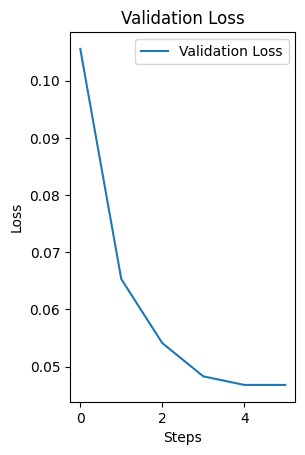

In [22]:
# Draw a graph

import matplotlib.pyplot as plt

# Assuming that 'history' is your training history
def plot_graphs(history):
    # Extract values from the history
    # accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
    training_loss = [x['loss'] for x in history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    steps = range(len(eval_loss))  # Assumes evaluation was done after each training step

    # # Accuracy
    # plt.figure(figsize=(12, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(steps, accuracy, label='Validation Accuracy')
    # plt.xlabel('Steps')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.title('Validation Accuracy')
    # Loss

    # plt.subplot(1, 2, 2)
    # plt.plot(steps, training_loss, label='Training Loss')
    # plt.xlabel('Steps')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Validation Loss')

    # plt.show()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(steps, eval_loss, label='Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Validation Loss')

    plt.show()

# Call the function
plot_graphs(trainer.state.log_history)


## Inference

In [ ]:
from datasets import load_metric
metric = load_metric("rouge")


<ipython-input-5-ffe5587f2e49>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [ ]:
import pandas as pd
train_file = '/colabDrive/MyDrive/colabDrive/miniDataset.csv'
# Read the CSV file using pandas
df = pd.read_csv(train_file)

# Convert the columns to lists
input_lines = df['AccentlessSentences'].tolist()
label_lines = df['Sentences'].tolist()

# Append '</s>' to each input line
input_lines = [line + '</s>' for line in input_lines]

dict_obj = {'inputs': input_lines, 'labels': label_lines}
dataset = Dataset.from_dict(dict_obj)
test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=10)

# input_lines = []
# label_lines = []
# with open(f'{task}/test.tsv') as file:
#   for line in file:
#     line = line.strip().split('\t')
#     input = line[0]
#     input_lines.append(input +'</s>')
#     label_lines.append(line[1])



# input_lines  = input_lines
# label_lines = label_lines
# dict_obj = {'inputs': input_lines, 'labels': label_lines}

# dataset = Dataset.from_dict(dict_obj)
# test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=10)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

Map (num_proc=10):   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3864: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3864: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3864: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('/colabDrive/MyDrive/colabDrive/myModelMini')
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
import torch
import numpy as np
metrics = load_metric('rouge')

max_target_length = 512
dataloader = torch.utils.data.DataLoader(test_tokenized_datasets, collate_fn=data_collator, batch_size=32)

predictions = []
references = []
for i, batch in enumerate(tqdm(dataloader)):
  outputs = model.generate(
      input_ids=batch['input_ids'].to('cuda'),
      max_length=max_target_length,
      attention_mask=batch['attention_mask'].to('cuda'),
  )
  with tokenizer.as_target_tokenizer():
    outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs]

    labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
    actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]
  predictions.extend(outputs)
  references.extend(actuals)
  metrics.add_batch(predictions=outputs, references=actuals)


metrics.compute()


  0%|          | 0/157 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3864: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'rouge1': AggregateScore(low=Score(precision=0.9992397743300422, recall=0.9993307083897525, fmeasure=0.9992763461503182), mid=Score(precision=0.9997596614950635, recall=0.9997805405405404, fmeasure=0.9997850415512465), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=0.9814101694915255, recall=0.9814985514984124, fmeasure=0.9814466412847879), mid=Score(precision=0.9850101694915254, recall=0.9850841742420946, fmeasure=0.9850392731071745), high=Score(precision=0.9882002542372881, recall=0.9882019825148971, fmeasure=0.9882009193854961)),
 'rougeL': AggregateScore(low=Score(precision=0.9992341325811002, recall=0.9993229356009314, fmeasure=0.9992698482875015), mid=Score(precision=0.99971706629055, recall=0.9997663326653307, fmeasure=0.9997374172185431), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=0.9992, recall=0.9992987547527487, fmeasure=0.9992121270018895), mid=Score(precision=0

In [ ]:
[{k: v.mid.fmeasure} for k,v in metrics.compute(predictions=predictions, references=references).items()]


[{'rouge1': 0.9997850415512465},
 {'rouge2': 0.9850392731071745},
 {'rougeL': 0.9997374172185431},
 {'rougeLsum': 0.9997875346260388}]